In [1]:
# import all required packages

import numpy as np # Maths functions, matrices 
import matplotlib.pyplot as plt # Plotting
import pandas as pd # data frames
import seaborn as sns #make heatmap
import requests, sys, tqdm # getting data from internet
from bs4 import BeautifulSoup # parsing html/xml data

This notebook shows you how to access and interact with the PURE effector dataset, and also how to query online databases. 

The aim of the project is to propose an optimal set of proteins to screen against the PURE system, in order to enhance its activity. We currently have a large dataset ([Katuza 2008](https://doi.org/10.1074/mcp.M800051-MCP200)) which screens almost every single ORF in E. coli against the PURE system, in a one-off manner. The dataset experimentally identifies 344 proteins which enhance the yield of the PURE system. 

Our hypothesis is that multiple proteins should enhance the system more significantly compared to single components. To test this we will experimentally screen sets of proteins against the PURE system. The screening set will consist of ~20 proteins, which is constrained by experimental capability. The challenge is to determine which proteins will go into this screening set. 

There are several possibilities. We could naively take the top 20 performing proteins from the set of 344 demonstrated enhancers. 

A more sophisticated approach would build on the idea that sets of proteins which together perform functions (for example, ribosome recycling systems) would be even better. In other words, we would like to consider interactions between proteins. A tool which enables this analysis is ([String](https://string-db.org/)). We might choose to take a component from the set of 344 enhancers, and use it in a screening set with all of its interaction partners.

In the end, we would like a set of 20 proteins which are most likely to synergistically enhance the performance of the PURE system. The result will be used to guide the first round of experimental screening. 

To start with, we would like the following information for the original 344 enhancers:

* what functions do they have? 
* is the enhancement likely to be specific or non-specific?
* which of these enhancers interact with each other, according to string-db?
* which of these enhancers interact with PURE system components?

In [2]:
# 1. Enhancers of the PURE system

In [3]:
# Load Katuza into a pandas dataframe
xls = pd.ExcelFile("./data/Katuza_ORFdata.xls")
df = pd.read_excel(xls,skiprows=9)


In [4]:
# Have a look at the data
df

,Locustag \nW3110,Locustag \nK-12,Locustag \nMG1655,Beneficial\ncomponents,Deleterious\ncomponents,Minimum\nprotein\ncomponents,Gene\nname,Rank,GFP \nFluorescence,Rank.1,Fluorescence,GFP \nfluorescence,Type of \ngene product,Gene \nproduct \ndescription,Number \nof \northolog \ncluster \nmember,Ortholog \ncluster \nname
0,JW5222,ECK1406,b1413,B,NaN,NaN,hrpA,1,0.603564,417,1.188677,NaN,e,ATP-dependent helicase,95,hrpA
1,JW0426,ECK0430,b0436,B,NaN,NaN,tig,2,0.573191,3900,3.020274,0.564210,e,peptidyl-prolyl cis/trans isomerase (trigger f...,164,tig
2,JW2566,ECK2580,b2582,B,NaN,NaN,trxC,3,0.564672,3447,2.366224,NaN,c,thioredoxin 2,158,trxA
3,JW4061,ECK4093,b4100,B,NaN,NaN,phnH,4,0.552994,1242,1.426786,0.536014,e,carbon-phosphorus lyase complex subunit,21,phnH
4,JW5412,ECK2599,b2602,B,NaN,NaN,yfiL,5,0.546307,2047,1.658802,NaN,o,predicted protein,11,yfiL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189,JW1555,ECK1557,b1563,NaN,D,NaN,relE,4185,0.000000,212,1.114010,NaN,h,Qin prophage; toxin of the RelE-RelB toxin-ant...,41,relE
4190,JW1644,ECK1648,b1652,NaN,D,NaN,rnt,4185,0.000000,3796,2.800703,NaN,e,ribonuclease T (RNase T),37,rnt
4191,JW1738,ECK1747,b1749,NaN,D,NaN,xthA,4185,0.000000,482,1.209639,NaN,e,exonuclease III,142,xthA
4192,JW3099,ECK3118,b3130,NaN,D,NaN,yhaV,4185,0.000000,38,0.989533,NaN,o,conserved protein,5,yhaV


In [5]:
# The enhancers have already been identified with 
# the label 'B'. Let's extract these components into
# a second data frame which we call 'enhancers'
enhancers = df[df['Beneficial\ncomponents']=='B']

In [6]:
# Look at the data
enhancers

,Locustag \nW3110,Locustag \nK-12,Locustag \nMG1655,Beneficial\ncomponents,Deleterious\ncomponents,Minimum\nprotein\ncomponents,Gene\nname,Rank,GFP \nFluorescence,Rank.1,Fluorescence,GFP \nfluorescence,Type of \ngene product,Gene \nproduct \ndescription,Number \nof \northolog \ncluster \nmember,Ortholog \ncluster \nname
0,JW5222,ECK1406,b1413,B,NaN,NaN,hrpA,1,0.603564,417,1.188677,NaN,e,ATP-dependent helicase,95,hrpA
1,JW0426,ECK0430,b0436,B,NaN,NaN,tig,2,0.573191,3900,3.020274,0.564210,e,peptidyl-prolyl cis/trans isomerase (trigger f...,164,tig
2,JW2566,ECK2580,b2582,B,NaN,NaN,trxC,3,0.564672,3447,2.366224,NaN,c,thioredoxin 2,158,trxA
3,JW4061,ECK4093,b4100,B,NaN,NaN,phnH,4,0.552994,1242,1.426786,0.536014,e,carbon-phosphorus lyase complex subunit,21,phnH
4,JW5412,ECK2599,b2602,B,NaN,NaN,yfiL,5,0.546307,2047,1.658802,NaN,o,predicted protein,11,yfiL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,JW3418,ECK3437,b3453,B,NaN,NaN,ugpB,340,0.463148,1947,1.626671,NaN,t,glycerol-3-phosphate transporter subunit -!- p...,51,ugpB
340,JW2665,ECK2685,b2690,B,NaN,NaN,yqaB,341,0.463130,1616,1.535660,NaN,pe,predicted hydrolase,152,gph
341,JW3546,ECK3563,b3574,B,NaN,NaN,yiaJ,342,0.462953,2262,1.726957,NaN,pr,predicted DNA-binding transcriptional repressor,71,iclR
342,JW0385,ECK0389,b0394,B,NaN,NaN,mak,343,0.462948,1580,1.524567,0.459539,e,manno(fructo)kinase,116,glcK


In [7]:
enhancers.to_excel('enhancers.xlsx')
xls1=pd.ExcelFile("./enhancers.xlsx")
df1=pd.read_excel("./enhancers.xlsx")
df1[['Locustag \nMG1655']]
a=df1['Locustag \nMG1655'].values.tolist()
cleanedList = [x for x in a if str(x) != 'nan']#enhancerlist without nan

print (cleanedList)
len (cleanedList)

['b1413', 'b0436', 'b2582', 'b4100', 'b2602', 'b2468', 'b4162', 'b3860', 'b3349', 'b1351', 'b4101', 'b2867', 'b2893', 'b3480', 'b2916', 'b2646', 'b3507', 'b4153', 'b2996', 'b3674', 'b3612', 'b2459', 'b4118', 'b4379', 'b2236', 'b3162', 'b4372', 'b4097', 'b3560', 'b2212', 'b2202', 'b2732', 'b2205', 'b2730', 'b4238', 'b4502', 'b2713', 'b0872', 'b0949', 'b3847', 'b3711', 'b0873', 'b3497', 'b2208', 'b4467', 'b2563', 'b1212', 'b3421', 'b3187', 'b2767', 'b2454', 'b1475', 'b4084', 'b4298', 'b2720', 'b3725', 'b2724', 'b4207', 'b2726', 'b3564', 'b3222', 'b2719', 'b2615', 'b3549', 'b3616', 'b1286', 'b3595', 'b3715', 'b0871', 'b2095', 'b1906', 'b2343', 'b1915', 'b2854', 'b2476', 'b4252', 'b3604', 'b2550', 'b3583', 'b3608', 'b4515', 'b1919', 'b4135', 'b4196', 'b2729', 'b1904', 'b3867', 'b3712', 'b2762', 'b3952', 'b4174', 'b2908', 'b3717', 'b2696', 'b2797', 'b2997', 'b2876', 'b2548', 'b2727', 'b2887', 'b4092', 'b3433', 'b1428', 'b3580', 'b2918', 'b4062', 'b3115', 'b2601', 'b2551', 'b4197', 'b4191', 

339

In [30]:
#isolate PURE components from enhancers list
df4=pd.read_excel("./PURE.xlsx")
PURE_list=df4['Locustag \nMG1655'].values.tolist()
enhancerlist= [i for i in cleanedList if i not in PURE_list]# 'enhancerlist' is the enhancers list without pure component and NAN
print(enhancerlist)
len (enhancerlist)

['b1413', 'b0436', 'b2582', 'b4100', 'b2602', 'b2468', 'b4162', 'b3860', 'b3349', 'b1351', 'b4101', 'b2867', 'b2893', 'b3480', 'b2916', 'b2646', 'b3507', 'b4153', 'b2996', 'b3674', 'b3612', 'b2459', 'b4118', 'b4379', 'b2236', 'b3162', 'b4372', 'b4097', 'b2212', 'b2202', 'b2732', 'b2205', 'b2730', 'b4238', 'b4502', 'b2713', 'b0872', 'b0949', 'b3847', 'b3711', 'b0873', 'b3497', 'b2208', 'b4467', 'b2563', 'b1212', 'b3421', 'b3187', 'b2767', 'b2454', 'b1475', 'b4084', 'b4298', 'b2720', 'b3725', 'b2724', 'b4207', 'b2726', 'b3564', 'b3222', 'b2719', 'b2615', 'b3549', 'b3616', 'b1286', 'b3595', 'b3715', 'b0871', 'b2095', 'b1906', 'b2343', 'b1915', 'b2854', 'b2476', 'b4252', 'b3604', 'b2550', 'b3583', 'b3608', 'b4515', 'b1919', 'b4135', 'b4196', 'b2729', 'b1904', 'b3867', 'b3712', 'b2762', 'b3952', 'b4174', 'b2908', 'b3717', 'b2696', 'b2797', 'b2997', 'b2876', 'b2548', 'b2727', 'b2887', 'b4092', 'b3433', 'b1428', 'b3580', 'b2918', 'b4062', 'b3115', 'b2601', 'b2551', 'b4197', 'b4191', 'b4192', 

337

In [37]:
enhancerlist= enhancers.loc[enhancers['Locustag \nMG1655'].isin(enhancerlist)]
enhancerlist.to_excel('./outputs/enhancerlist.xlsx')

In [8]:
#non enhancers
Katuza_list=df['Locustag \nMG1655'].values.tolist()
enhancers_list=df1['Locustag \nMG1655'].values.tolist()
nonenhancers= [i for i in Katuza_list if i not in enhancers_list]
len (nonenhancers)

3785

In [9]:
print (nonenhancers)

['b3916', 'b4462', 'b2124', 'b2398', 'b1526', 'b3626', 'b3211', 'b1297', 'b2583', 'b3308', 'b1963', 'b3225', 'b3450', 'b2776', 'b4096', 'b0947', 'b3721', 'b4267', 'b3972', 'b3771', 'b2972', 'b2880', 'b4014', 'b2632', 'b2171', 'b4209', 'b3908', 'b3990', 'b1182', 'b2992', 'b4232', 'b3946', 'b3481', 'b2359', 'b2040', 'b3625', 'b3201', 'b2871', 'b4226', 'b0645', 'b2593', 'b2631', 'b3189', 'b4173', 'b2957', 'b0607', 'b1393', 'b3591', 'b4171', 'b3934', 'b2800', 'b0561', 'b3359', 'b1137', 'b3817', 'b1774', 'b0604', 'b4281', 'b3615', 'b4142', 'b2660', 'b1055', 'b3613', 'b1050', 'b3355', 'b3500', 'b2868', 'b2755', 'b2087', 'b1803', 'b2024', 'b2573', 'b3149', 'b4204', 'b1628', 'b0846', 'b2714', 'b3856', 'b3631', 'b4293', 'b2834', 'b1064', 'b1044', 'b3961', 'b3374', 'b1760', 'b2741', 'b3745', 'b3639', 'b3881', 'b1100', 'b0621', 'b3351', 'b3618', 'b3238', 'b3635', 'b2765', 'b3021', 'b1414', 'b2623', 'b3028', 'b2669', 'b1021', 'b3520', 'b4103', 'b2112', 'b1579', 'b0895', 'b2674', 'b0226', 'b4363', 

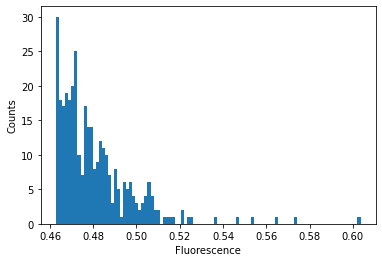

In [10]:
# If we look at the fluorescence data for these
# components we see they are higher than the 
# average (=0.443), which makes sense as they are
# enhancers
fig, ax = plt.subplots();
ax.hist(enhancers['GFP \nFluorescence'],bins=100);
ax.set_xlabel('Fluorescence');
ax.set_ylabel('Counts');
plt.savefig('./outputs/fluor_enhancers.pdf');
plt.show();

In [11]:
#all of the enzymes in Katuza_data
allenzymes = df[df['Type of \ngene product']=='e']
allenzymes.to_excel('allenzymes.xlsx')
# look at data
allenzymes

,Locustag \nW3110,Locustag \nK-12,Locustag \nMG1655,Beneficial\ncomponents,Deleterious\ncomponents,Minimum\nprotein\ncomponents,Gene\nname,Rank,GFP \nFluorescence,Rank.1,Fluorescence,GFP \nfluorescence,Type of \ngene product,Gene \nproduct \ndescription,Number \nof \northolog \ncluster \nmember,Ortholog \ncluster \nname
0,JW5222,ECK1406,b1413,B,NaN,NaN,hrpA,1,0.603564,417,1.188677,NaN,e,ATP-dependent helicase,95,hrpA
1,JW0426,ECK0430,b0436,B,NaN,NaN,tig,2,0.573191,3900,3.020274,0.564210,e,peptidyl-prolyl cis/trans isomerase (trigger f...,164,tig
3,JW4061,ECK4093,b4100,B,NaN,NaN,phnH,4,0.552994,1242,1.426786,0.536014,e,carbon-phosphorus lyase complex subunit,21,phnH
6,JW5740,ECK4158,b4162,B,NaN,NaN,orn,7,0.525488,1536,1.514090,0.472933,e,oligoribonuclease,68,orn
7,JW3832,ECK3852,b3860,B,NaN,NaN,dsbA,8,0.523529,3978,3.221229,0.419854,e,periplasmic protein disulfide isomerase I,51,dsbA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,JW3835,ECK3855,b3863,NaN,D,NaN,polA,4185,0.000000,33,0.980688,0.000000,e,fused DNA polymerase I 5'->3' exonuclease -!- ...,165,polA
4187,JW1269,ECK1272,b1277,NaN,D,NaN,ribA,4185,0.000000,2758,1.924284,0.000000,e,GTP cyclohydrolase II,150,ribA
4188,JW2753,ECK2776,b2782,NaN,D,NaN,chpA,4185,0.000000,1170,1.408157,NaN,e,"toxin of the ChpA-ChpR toxin-antitoxin system,...",56,chpA
4190,JW1644,ECK1648,b1652,NaN,D,NaN,rnt,4185,0.000000,3796,2.800703,NaN,e,ribonuclease T (RNase T),37,rnt


In [12]:
# The function, of the protein is represented
# by letters in the 'Type of gene product' column.
# For instance, 'e' represents enzymes, and to get 
# all of the enzymes in enhancers subset, we can call
enzymes = enhancers[enhancers['Type of \ngene product']=='e']
enzymes.to_excel('enzymes.xlsx')
# look at data
enzymes

,Locustag \nW3110,Locustag \nK-12,Locustag \nMG1655,Beneficial\ncomponents,Deleterious\ncomponents,Minimum\nprotein\ncomponents,Gene\nname,Rank,GFP \nFluorescence,Rank.1,Fluorescence,GFP \nfluorescence,Type of \ngene product,Gene \nproduct \ndescription,Number \nof \northolog \ncluster \nmember,Ortholog \ncluster \nname
0,JW5222,ECK1406,b1413,B,NaN,NaN,hrpA,1,0.603564,417,1.188677,NaN,e,ATP-dependent helicase,95,hrpA
1,JW0426,ECK0430,b0436,B,NaN,NaN,tig,2,0.573191,3900,3.020274,0.564210,e,peptidyl-prolyl cis/trans isomerase (trigger f...,164,tig
3,JW4061,ECK4093,b4100,B,NaN,NaN,phnH,4,0.552994,1242,1.426786,0.536014,e,carbon-phosphorus lyase complex subunit,21,phnH
6,JW5740,ECK4158,b4162,B,NaN,NaN,orn,7,0.525488,1536,1.514090,0.472933,e,oligoribonuclease,68,orn
7,JW3832,ECK3852,b3860,B,NaN,NaN,dsbA,8,0.523529,3978,3.221229,0.419854,e,periplasmic protein disulfide isomerase I,51,dsbA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,JW0761,ECK0767,b0778,B,NaN,NaN,bioD,334,0.463323,3741,2.709758,NaN,e,dethiobiotin synthetase,114,bioD
334,JW0890,ECK0898,b0907,B,NaN,NaN,serC,335,0.463321,2059,1.664448,0.450972,e,3-phosphoserine/phosphohydroxythreonine aminot...,111,serC
337,JW3553,ECK3570,b3581,B,NaN,NaN,sgbH,338,0.463174,3695,2.638257,NaN,e,3-keto-L-gulonate 6-phosphate decarboxylase,24,sgbH
342,JW0385,ECK0389,b0394,B,NaN,NaN,mak,343,0.462948,1580,1.524567,0.459539,e,manno(fructo)kinase,116,glcK


In [13]:
df2=pd.read_excel("./enzymes.xlsx")
enzymes_list=df2['Locustag \nMG1655'].values.tolist()
nonenzymes_list= [i for i in enhancers_list if i not in enzymes_list]
print (nonenzymes_list)
len (nonenzymes_list)

['b2582', 'b2602', 'b2468', 'b1351', 'b3480', 'b2916', 'b2646', 'b3507', 'b4153', 'b2996', 'b3674', 'b2459', 'b4118', 'b4379', 'b2236', 'b2202', 'b2732', 'b2205', 'b4502', 'b2713', 'b0949', 'b3711', 'b0873', 'b3497', 'b2208', 'b4467', 'b3421', 'b2767', 'b2454', 'b1475', 'b4298', 'b2720', 'b3725', 'b2724', 'b2726', 'b3222', nan, 'b3595', 'b3715', 'b1906', 'b2343', 'b1915', 'b2854', 'b4252', 'b3604', 'b2550', 'b4515', 'b4135', 'b2729', 'b1904', 'b3712', 'b4174', 'b3717', 'b2696', 'b2876', 'b2548', 'b2887', 'b1428', 'b2918', 'b4062', 'b4191', 'b1317', 'b2098', nan, 'b2204', 'b2570', 'b3381', 'b2474', 'b4089', 'b2846', 'b1776', 'b2633', 'b2840', 'b0710', 'b0711', 'b1406', 'b3900', 'b2460', 'b2617', 'b3681', 'b1391', 'b4104', 'b3120', 'b2575', 'b4071', 'b1895', 'b1287', 'b4567', 'b2467', 'b2955', 'b3488', 'b0713', 'b1671', 'b3768', 'b3781', 'b2201', 'b2645', 'b2895', 'b3249', 'b0835', 'b3410', 'b2626', 'b2886', 'b3422', 'b3105', 'b3682', 'b4026', 'b1119', 'b2667', 'b4175', nan, 'b3684', 'b3

223

[121, 223]
['enzymes', 'nonenzymes']


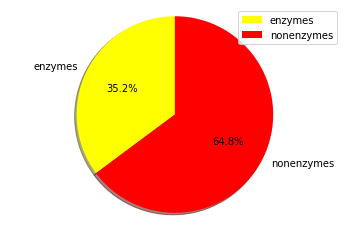

In [14]:
#proportion:enzymes in enhancers
topic = ['enzymes', 'nonenzymes']
Postive_percentage = [121, 223]
sizes = Postive_percentage
print(sizes)
labels = list(topic)
# makeitastring = ''.join(map(str, labels))
print(labels)
colors = ['yellow', 'red']
plt.pie(sizes, explode=None, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)   
#plt.pie(sizes, labels, colors)
plt.axis('equal')
plt.legend()
plt.savefig('./outputs/pie/pie1.pdf');
plt.show()

In [15]:
#enzymes in nonenhancers
df3=pd.read_excel("./allenzymes.xlsx")
allenzymes_list=df3['Locustag \nMG1655'].values.tolist()
nonenhancers_list= [i for i in Katuza_list if i not in enhancers_list]
co= [x for x in nonenhancers_list if x in allenzymes_list]  # enzymes in nonenhancers
len(co) #how many 

954

In [16]:
nonenzymes_list= [i for i in nonenhancers_list if i not in allenzymes_list]
len (nonenzymes_list)

2831

[954, 2831]
['enzymes', 'nonenzymes']


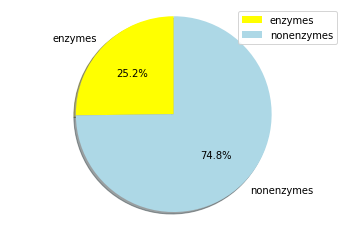

In [17]:
#proportion:enzymes in nonenhancers
topic = ['enzymes', 'nonenzymes']
Postive_percentage = [954, 2831]
sizes = Postive_percentage
print(sizes)
labels = list(topic)
# makeitastring = ''.join(map(str, labels))
print(labels)
colors = ['yellow', 'lightblue']
plt.pie(sizes, explode=None, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)   
#plt.pie(sizes, labels, colors)
plt.axis('equal')
plt.legend()
plt.savefig('./outputs/pie/pie2.pdf');
plt.show()

In [18]:
allenzymes_list=df3['Locustag \nMG1655'].values.tolist()
Katuza_list=df['Locustag \nMG1655'].values.tolist()
co= [x for x in Katuza_list if x in allenzymes_list]  # enzymes in Kauzuta list
len(co) #how many 

1075

In [19]:
nonenzymes_list= [i for i in Katuza_list if i not in allenzymes_list]
len (nonenzymes_list)

3119

[1075, 3119]
['enzymes', 'nonenzymes']


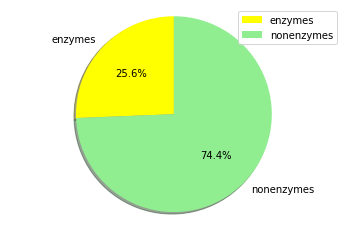

In [20]:
#proportion:enzymes in all data
topic = ['enzymes', 'nonenzymes']
Postive_percentage = [1075, 3119]
sizes = Postive_percentage
print(sizes)
labels = list(topic)
# makeitastring = ''.join(map(str, labels))
print(labels)
colors = ['yellow', 'lightgreen']
plt.pie(sizes, explode=None, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)   
#plt.pie(sizes, labels, colors)
plt.axis('equal')
plt.legend()
plt.savefig('./outputs/pie/pie3.pdf');
plt.show()

In [ ]:
#We have the protein-protein interaction data from string-db downloaded into a text file, for E. coli K12 MG1655, 
#which is represented by the NCBI taxonomy ID 511145. 
#Each protein is represented by a string-db code, and every pairwise interaction is given a string-db score . 
#The string-db code for our proteins is listed in the column entitled 'Locustag MG1655' in the original dataset.

In [22]:
#interactoion data
interact = pd.read_csv('./data/511145.protein.links.v11.0.txt', sep=" ")  # https://string-db.org/

In [23]:
# look at data
interact

,protein1,protein2,combined_score
0,511145.b0001,511145.b3766,354
1,511145.b0001,511145.b2483,430
2,511145.b0001,511145.b0075,303
3,511145.b0001,511145.b3672,408
4,511145.b0001,511145.b0861,306
...,...,...,...
1060849,511145.b4706,511145.b4421,920
1060850,511145.b4706,511145.b3846,236
1060851,511145.b4706,511145.b4082,809
1060852,511145.b4706,511145.b4662,830


In [24]:
#high confidence
interact[interact['combined_score']>950]

,protein1,protein2,combined_score
83,511145.b0002,511145.b4013,952
280,511145.b0002,511145.b4019,958
518,511145.b0002,511145.b0004,999
535,511145.b0002,511145.b3433,982
627,511145.b0002,511145.b0003,999
...,...,...,...
1058621,511145.b4572,511145.b0518,995
1058701,511145.b4588,511145.b4509,958
1058804,511145.b4592,511145.b4515,952
1060219,511145.b4675,511145.b4676,985


In [25]:
#high confidence
df5=interact[interact['combined_score']>950]
df5.to_excel('./outputs/highscore.xlsx')

In [26]:
# adjust the data by removing all the '511145.'    
# make a dataset named 'high' for selecting enhancers from the interaction list
# read the 'high' data
df6=pd.read_excel("./outputs/interaction.xlsx")

In [27]:
#protein1 from enhancerlist,  protein2 from Katuza list, score>950
#list1'Locustag \nMG1655' is the enhancers list without PURE components
df6.loc[df6['protein1'].isin(enhancerlist)] 

,Unnamed: 0,protein1,protein2,combined_score
549,32634,b0120,b0121,999
646,42550,b0161,b3347,977
647,42792,b0161,b0957,963
648,42811,b0161,b2215,989
1213,88626,b0394,b2169,956
...,...,...,...,...
15307,1045852,b4467,b2976,989
15308,1045865,b4467,b4468,999
15362,1051855,b4515,b0733,982
15363,1051933,b4515,b0734,986


In [28]:
interact1=df6.loc[df6['protein1'].isin(enhancerlist)]
interact1.to_csv("./outputs/interact1.csv")

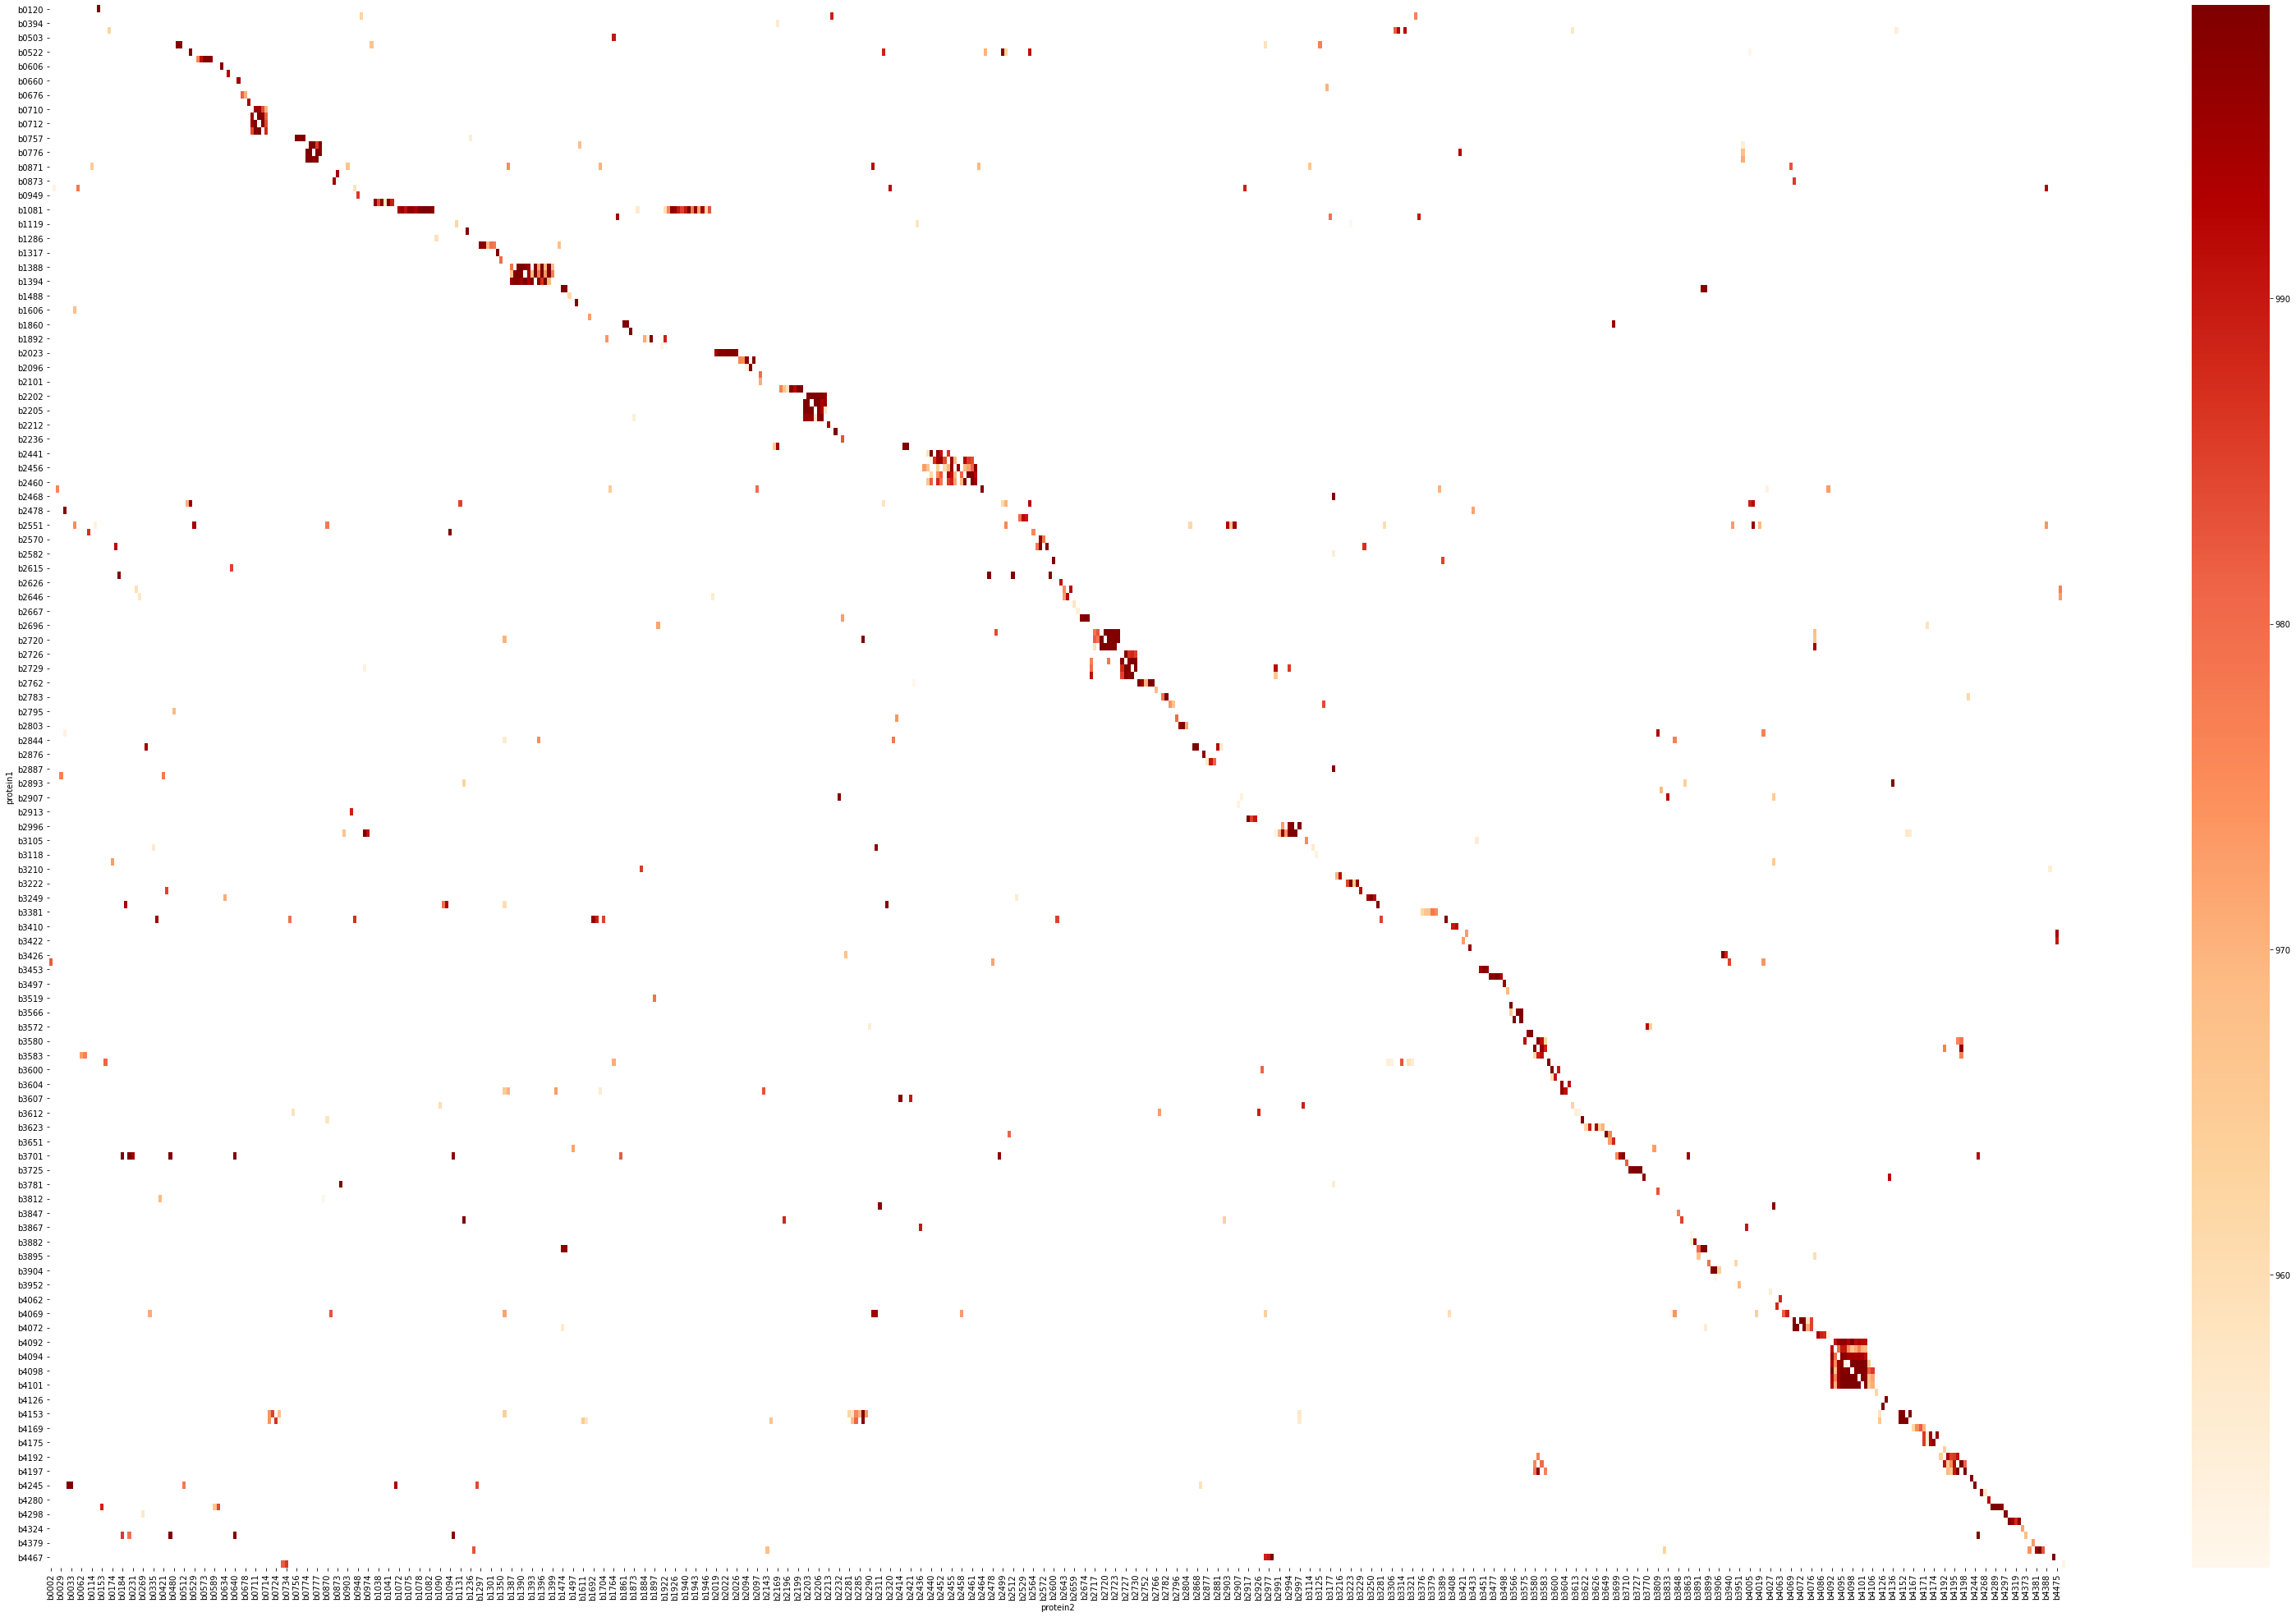

In [29]:
data = pd.read_csv("./outputs/interact1.csv")
pivot = data.pivot(index='protein1', columns='protein2',values='combined_score')
plt.figure(figsize=(55, 35))
ax = sns.heatmap(pivot,cmap="OrRd")
plt.show()
figure = ax.get_figure()    
figure.savefig('./outputs/heatmap/interact1.pdf')

In [30]:
#protein1 from enhancerlist,  protein2 from PURE list, score>950
df7=df6.loc[df6['protein1'].isin(enhancerlist)]
df7.loc[df7['protein2'].isin(PURE_list)]

,Unnamed: 0,protein1,protein2,combined_score
1362,101574,b0436,b0170,963
3598,291400,b1212,b1211,999
7298,592973,b2551,b3288,960


In [31]:
interact2=df7.loc[df7['protein2'].isin(PURE_list)]
interact2.to_csv("./outputs/interact2.csv")

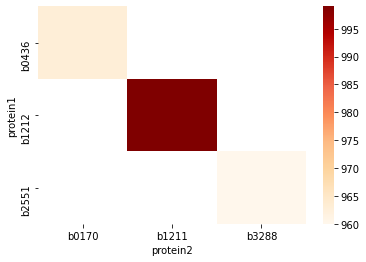

In [32]:
data = pd.read_csv("./outputs/interact2.csv")
pivot = data.pivot(index='protein1', columns='protein2',values='combined_score')
ax = sns.heatmap(pivot,cmap="OrRd")
plt.show()
figure = ax.get_figure()    
figure.savefig('./outputs/heatmap/interact2.pdf')

In [33]:
#protein1 & protein2 from enhancerlist score>950
df7.loc[df7['protein2'].isin(enhancerlist)]

,Unnamed: 0,protein1,protein2,combined_score
1511,122531,b0522,b2476,970
1868,163514,b0710,b0712,995
1869,163535,b0710,b0711,995
1871,163640,b0710,b0713,984
1872,163675,b0711,b0710,995
...,...,...,...,...
14751,1000372,b4196,b3580,976
14754,1000406,b4197,b3583,977
14756,1000421,b4197,b4196,999
14758,1000427,b4197,b3581,997


In [35]:
interact3=df7.loc[df7['protein2'].isin(enhancerlist)]
interact3.to_csv("./outputs/interact3.csv")

In [36]:
liste=interact3['protein1'].values.tolist()
listee={}.fromkeys(liste).keys()
len (listee)

82

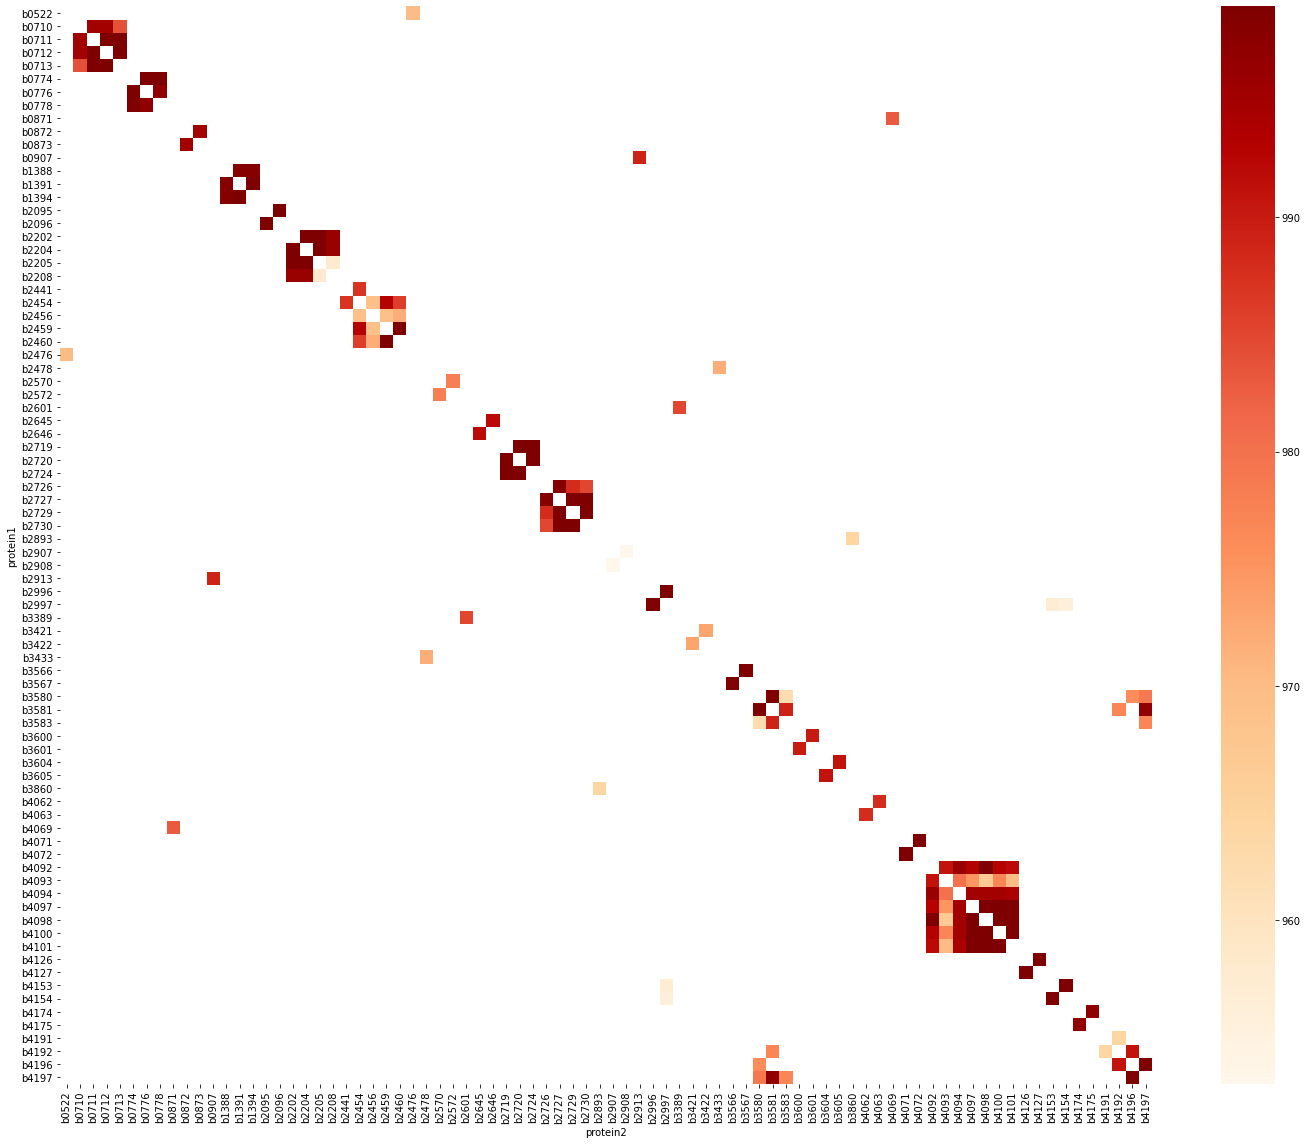

In [37]:
data = pd.read_csv("./outputs/interact3.csv")
pivot = data.pivot(index='protein1', columns='protein2',values='combined_score')
plt.figure(figsize=(20, 16))
ax = sns.heatmap(pivot,cmap="OrRd")
plt.tight_layout()
plt.show()
figure = ax.get_figure()    
figure.savefig('./outputs/heatmap/interact3.pdf')

In [38]:
liste=interact3['protein1'].values.tolist()
e1 = {}
for i in liste:
  if liste.count(i)>2:
    e1[i] = liste.count(i)
print (e1)
len (e1)

{'b0710': 3, 'b0711': 3, 'b0712': 3, 'b0713': 3, 'b2202': 3, 'b2204': 3, 'b2205': 3, 'b2208': 3, 'b2454': 4, 'b2456': 3, 'b2459': 3, 'b2460': 3, 'b2726': 3, 'b2727': 3, 'b2729': 3, 'b2730': 3, 'b2997': 3, 'b3580': 4, 'b3581': 4, 'b3583': 3, 'b4092': 6, 'b4093': 6, 'b4094': 6, 'b4097': 6, 'b4098': 6, 'b4100': 6, 'b4101': 6, 'b4192': 3, 'b4196': 3, 'b4197': 4}


30

In [39]:
interact3.loc[interact3['protein1'].isin(e1)]

,Unnamed: 0,protein1,protein2,combined_score
1868,163514,b0710,b0712,995
1869,163535,b0710,b0711,995
1871,163640,b0710,b0713,984
1872,163675,b0711,b0710,995
1874,163705,b0711,b0713,999
...,...,...,...,...
14751,1000372,b4196,b3580,976
14754,1000406,b4197,b3583,977
14756,1000421,b4197,b4196,999
14758,1000427,b4197,b3581,997


In [40]:
df8=interact3.loc[interact3['protein1'].isin(e1)]
df8.to_csv("./outputs/partners.csv")

In [41]:
#protein1 from enhancerlist,  protein2 from nonenhancers list, score>950
df7.loc[df7['protein2'].isin(nonenhancers)]

,Unnamed: 0,protein1,protein2,combined_score
549,32634,b0120,b0121,999
646,42550,b0161,b3347,977
647,42792,b0161,b0957,963
648,42811,b0161,b2215,989
1213,88626,b0394,b2169,956
...,...,...,...,...
15306,1045774,b4467,b2977,990
15307,1045852,b4467,b2976,989
15308,1045865,b4467,b4468,999
15362,1051855,b4515,b0733,982


In [42]:
interact4=df7.loc[df7['protein2'].isin(nonenhancers)]
interact4.to_csv("./outputs/interact4.csv")

In [43]:
listee=interact4['protein1'].values.tolist()
e2 = {}
for i in listee:
  if listee.count(i)>2:
    e2[i] = listee.count(i)
print (e2)
len (e2)

{'b0161': 3, 'b0436': 6, 'b0507': 5, 'b0522': 6, 'b0572': 5, 'b0757': 4, 'b0774': 4, 'b0776': 4, 'b0778': 3, 'b0871': 7, 'b0907': 5, 'b1042': 6, 'b1081': 26, 'b1096': 3, 'b1119': 3, 'b1298': 6, 'b1388': 8, 'b1391': 9, 'b1394': 8, 'b1475': 4, 'b1892': 5, 'b2023': 7, 'b2095': 3, 'b2201': 7, 'b2208': 3, 'b2416': 4, 'b2441': 4, 'b2454': 6, 'b2456': 8, 'b2459': 7, 'b2460': 8, 'b2465': 7, 'b2476': 8, 'b2531': 3, 'b2551': 14, 'b2563': 3, 'b2572': 4, 'b2617': 4, 'b2645': 3, 'b2646': 4, 'b2675': 4, 'b2719': 6, 'b2720': 8, 'b2724': 5, 'b2727': 3, 'b2729': 5, 'b2730': 3, 'b2762': 6, 'b2783': 3, 'b2787': 3, 'b2803': 3, 'b2838': 3, 'b2844': 4, 'b2867': 5, 'b2907': 3, 'b2918': 3, 'b2996': 3, 'b2997': 9, 'b3115': 3, 'b3215': 3, 'b3222': 4, 'b3249': 5, 'b3256': 6, 'b3381': 5, 'b3389': 7, 'b3426': 3, 'b3433': 3, 'b3453': 3, 'b3480': 4, 'b3572': 3, 'b3583': 3, 'b3590': 8, 'b3605': 6, 'b3608': 3, 'b3612': 5, 'b3623': 6, 'b3648': 3, 'b3701': 13, 'b3725': 4, 'b3860': 3, 'b3893': 5, 'b3904': 3, 'b4069': 12,

107

In [44]:
interact4.loc[interact4['protein1'].isin(e2)]

,Unnamed: 0,protein1,protein2,combined_score
646,42550,b0161,b3347,977
647,42792,b0161,b0957,963
648,42811,b0161,b2215,989
1359,101053,b0436,b3312,992
1360,101477,b0436,b3309,982
...,...,...,...,...
15265,1037571,b4382,b4381,995
15305,1045773,b4467,b2979,999
15306,1045774,b4467,b2977,990
15307,1045852,b4467,b2976,989


In [45]:
df9=interact4.loc[interact4['protein1'].isin(e2)]
df9.to_csv("./outputs/partner_s.csv")

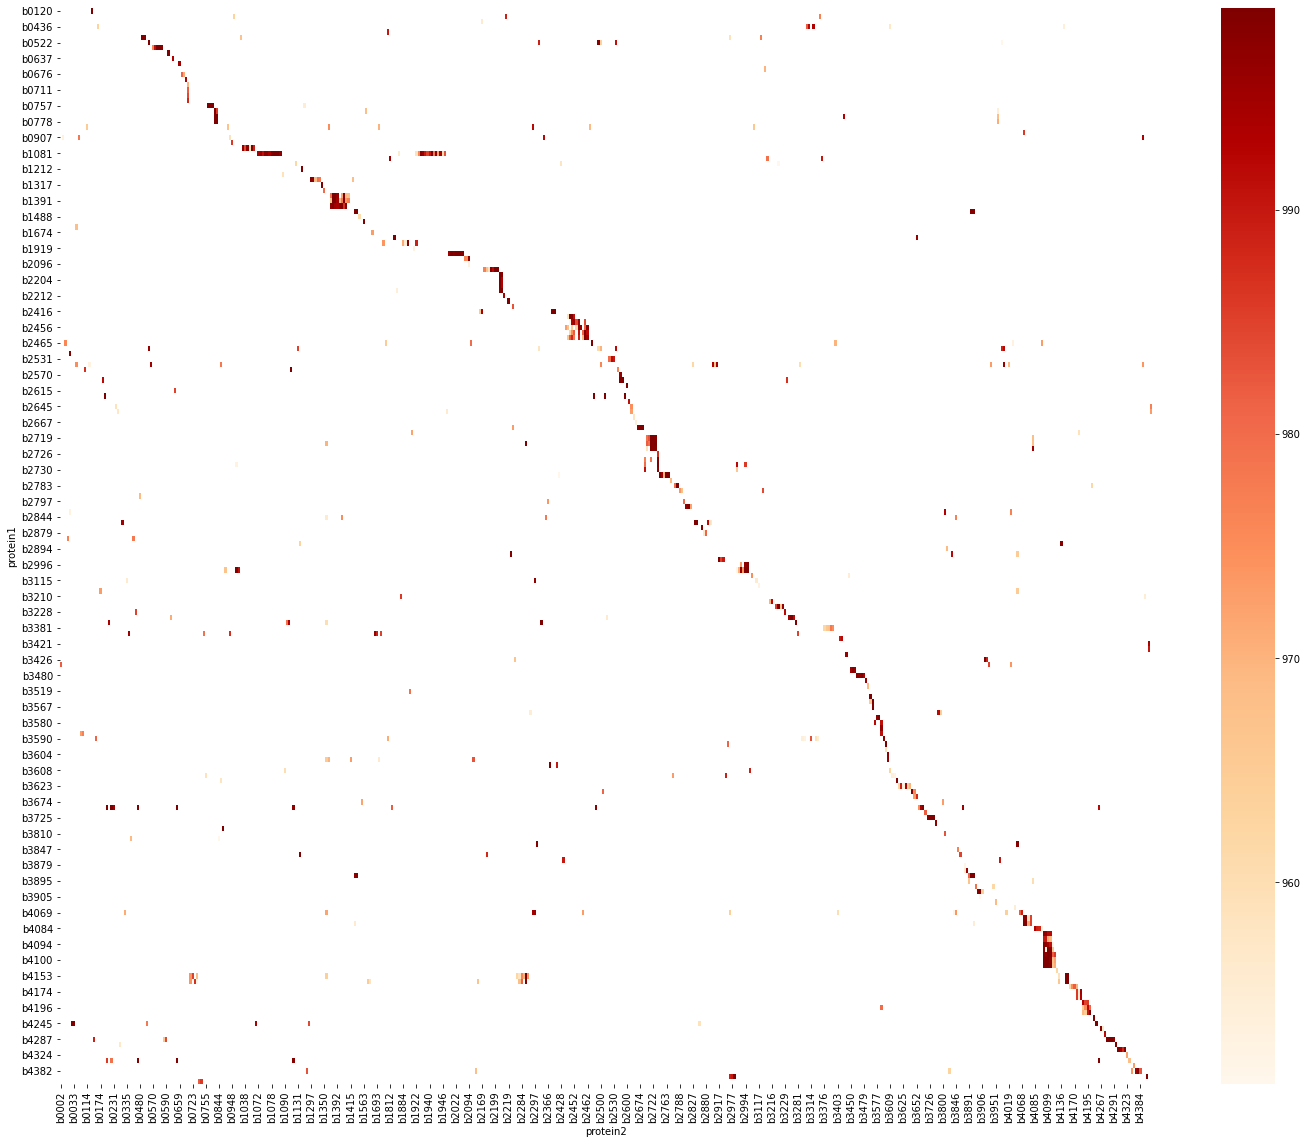

In [46]:
data = pd.read_csv("./outputs/interact4.csv")
pivot = data.pivot(index='protein1', columns='protein2',values='combined_score')
plt.figure(figsize=(20, 16))
ax = sns.heatmap(pivot,cmap="OrRd")
plt.tight_layout()
plt.show()
figure = ax.get_figure()    
figure.savefig('./outputs/heatmap/interact4.pdf')

In [47]:
#protiens that can interact with both enhancers and non enhancers more than two parternes, score>950
liste1=e1
liste2=e2
coe= [x for x in liste1 if x in liste2] 
print(coe)
len (coe)


['b2208', 'b2454', 'b2456', 'b2459', 'b2460', 'b2727', 'b2729', 'b2730', 'b2997', 'b3583', 'b4092', 'b4093', 'b4094', 'b4097', 'b4098', 'b4100', 'b4101', 'b4192', 'b4196', 'b4197']


20

In [48]:
uncoe=[x for x in liste2 if x not in liste1]
print(uncoe)

['b0161', 'b0436', 'b0507', 'b0522', 'b0572', 'b0757', 'b0774', 'b0776', 'b0778', 'b0871', 'b0907', 'b1042', 'b1081', 'b1096', 'b1119', 'b1298', 'b1388', 'b1391', 'b1394', 'b1475', 'b1892', 'b2023', 'b2095', 'b2201', 'b2416', 'b2441', 'b2465', 'b2476', 'b2531', 'b2551', 'b2563', 'b2572', 'b2617', 'b2645', 'b2646', 'b2675', 'b2719', 'b2720', 'b2724', 'b2762', 'b2783', 'b2787', 'b2803', 'b2838', 'b2844', 'b2867', 'b2907', 'b2918', 'b2996', 'b3115', 'b3215', 'b3222', 'b3249', 'b3256', 'b3381', 'b3389', 'b3426', 'b3433', 'b3453', 'b3480', 'b3572', 'b3590', 'b3605', 'b3608', 'b3612', 'b3623', 'b3648', 'b3701', 'b3725', 'b3860', 'b3893', 'b3904', 'b4069', 'b4071', 'b4072', 'b4084', 'b4153', 'b4154', 'b4169', 'b4174', 'b4175', 'b4245', 'b4287', 'b4317', 'b4372', 'b4382', 'b4467']


In [49]:
liste3=interact2['protein1'].values.tolist()
print (liste3)

['b0436', 'b1212', 'b2551']


In [50]:

result = []
for element in liste1:
    result.append(element)

for element in liste3:
    result.append(element)

print(result)

screenlist=result

['b0710', 'b0711', 'b0712', 'b0713', 'b2202', 'b2204', 'b2205', 'b2208', 'b2454', 'b2456', 'b2459', 'b2460', 'b2726', 'b2727', 'b2729', 'b2730', 'b2997', 'b3580', 'b3581', 'b3583', 'b4092', 'b4093', 'b4094', 'b4097', 'b4098', 'b4100', 'b4101', 'b4192', 'b4196', 'b4197', 'b0436', 'b1212', 'b2551']


In [ ]:
#We can query Uniprot for more information about any protein. All we need is its ID. The data we get is in a format called XML; run the following cell to get the data for a specific protein, 
#and save the bits you want into a dataframe


In [51]:
# Getting more information about slected protein

data_dicts = []
IDs = screenlist
for ID in tqdm.tqdm(IDs):

    # Get uniprot data for proteins
    # Documentation: https://www.ebi.ac.uk/proteins/api/doc/#!/proteins/search
    baseURL="https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=1&organism=Escherichia%20coli&gene="
    requestURL =baseURL+ID
    r = requests.get(requestURL)
    soup = BeautifulSoup(r.text, "xml")
    print(soup.prettify()) # print all data
    try:
        name = soup.find("fullName").text

        # Get sequence. Tag may occur more than once: find the right one
        seqs=soup.find_all("sequence")
        j=0
        while seqs[j].get("mass")==None:
            j+=1
        sequence = seqs[j].text
        mass = int(seqs[j].get("mass"))
        length = int(seqs[j].get("length"))
    

        data_dicts.append({'Name': name,
                           'ID': ID,
                           'Length': length,
                           'Mass (Da)': mass})
    except:
        print('Exception for '+ID)
        
        
# Let's save only the ID, name, length, and mass in Da:
selecteddata = pd.DataFrame.from_records(data_dicts, 
                               index='ID',
                              columns=['ID','Name','Length','Mass (Da)'])
selecteddata.to_excel('./outputs/screenlist.xlsx')

  6%|████████▏                                                                                                                              | 2/33 [00:00<00:06,  4.46it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2005-12-20" dataset="Swiss-Prot" modified="2021-06-02" version="113" xmlns="http://uniprot.org/uniprot">
  <accession>
   P0AFP6
  </accession>
  <accession>
   P75743
  </accession>
  <name>
   GCH1L_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="4">
     GTP cyclohydrolase 1 type 2 homolog
    </fullName>
   </recommendedName>
   <alternativeName>
    <fullName evidence="3">
     Radiation resistance protein YbgI
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    ybgI
   </name>
   <name type="ordered locus">
    b0710
   </name>
   <name type="ordered locus">
    JW0700
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
   </name

  9%|████████████▎                                                                                                                          | 3/33 [00:00<00:05,  5.06it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1997-11-01" dataset="Swiss-Prot" modified="2021-06-02" version="135" xmlns="http://uniprot.org/uniprot">
  <accession>
   P75745
  </accession>
  <name>
   PXPC_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="4">
     5-oxoprolinase subunit C
    </fullName>
    <shortName evidence="4">
     5-OPase subunit C
    </shortName>
    <ecNumber evidence="2">
     3.5.2.9
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName evidence="4">
     5-oxoprolinase (ATP-hydrolyzing) subunit C
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name evidence="3" type="primary">
    pxpC
   </name>
   <name type="synonym">
    ybgK
   </name>
   <name type="ordered locus">
    b0712
   </name>
   <n

 15%|████████████████████▍                                                                                                                  | 5/33 [00:01<00:05,  4.97it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1997-11-01" dataset="Swiss-Prot" modified="2021-06-02" version="136" xmlns="http://uniprot.org/uniprot">
  <accession>
   P75746
  </accession>
  <name>
   PXPA_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="1 4">
     5-oxoprolinase subunit A
    </fullName>
    <shortName evidence="1 4">
     5-OPase subunit A
    </shortName>
    <ecNumber evidence="1 2">
     3.5.2.9
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName evidence="1 4">
     5-oxoprolinase (ATP-hydrolyzing) subunit A
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name evidence="1 3" type="primary">
    pxpA
   </name>
   <name type="synonym">
    ybgL
   </name>
   <name type="ordered locus">
    b0713
   </n

 21%|████████████████████████████▋                                                                                                          | 7/33 [00:01<00:05,  4.39it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1994-02-01" dataset="Swiss-Prot" modified="2021-06-02" version="158" xmlns="http://uniprot.org/uniprot">
  <accession>
   P33934
  </accession>
  <accession>
   Q2MAN9
  </accession>
  <name>
   NAPH_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="6">
     Ferredoxin-type protein NapH
    </fullName>
   </recommendedName>
   <alternativeName>
    <fullName evidence="6">
     Ubiquinol--[NapC cytochrome c] reductase NapH subunit
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    napH
   </name>
   <name type="synonym">
    yejZ
   </name>
   <name type="ordered locus">
    b2204
   </name>
   <name type="ordered locus">
    JW2192
   </name>
  </gene>
  <organism>
   <name type=

 24%|████████████████████████████████▋                                                                                                      | 8/33 [00:01<00:05,  4.72it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2005-10-11" dataset="Swiss-Prot" modified="2021-06-02" version="111" xmlns="http://uniprot.org/uniprot">
  <accession>
   P0AAL0
  </accession>
  <accession>
   P33939
  </accession>
  <name>
   NAPF_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="1 5">
     Ferredoxin-type protein NapF
    </fullName>
   </recommendedName>
  </protein>
  <gene>
   <name evidence="1" type="primary">
    napF
   </name>
   <name type="synonym">
    yojG
   </name>
   <name type="ordered locus">
    b2208
   </name>
   <name type="ordered locus">
    JW2196
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
   </name>
   <dbReference id="83333" type="NCBI Taxonomy"/>
   <lineage>
    <taxo

 27%|████████████████████████████████████▊                                                                                                  | 9/33 [00:02<00:06,  3.69it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1997-11-01" dataset="Swiss-Prot" modified="2021-06-02" version="109" xmlns="http://uniprot.org/uniprot">
  <accession>
   P77277
  </accession>
  <name>
   EUTJ_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Ethanolamine utilization protein EutJ
    </fullName>
   </recommendedName>
  </protein>
  <gene>
   <name type="primary">
    eutJ
   </name>
   <name type="synonym">
    yffW
   </name>
   <name type="ordered locus">
    b2454
   </name>
   <name type="ordered locus">
    JW2438
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
   </name>
   <dbReference id="83333" type="NCBI Taxonomy"/>
   <lineage>
    <taxon>
     Bacteria
    </taxon>
    <taxon>
     Proteobacte

 30%|████████████████████████████████████████▌                                                                                             | 10/33 [00:02<00:06,  3.53it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2005-12-20" dataset="Swiss-Prot" modified="2021-06-02" version="105" xmlns="http://uniprot.org/uniprot">
  <accession>
   P0AEJ8
  </accession>
  <accession>
   P77633
  </accession>
  <name>
   EUTN_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="5">
     Bacterial microcompartment vertex protein EutN
    </fullName>
   </recommendedName>
   <alternativeName>
    <fullName evidence="6">
     Ethanolamine catabolic microcompartment shell protein EutN
    </fullName>
   </alternativeName>
   <alternativeName>
    <fullName>
     Ethanolamine utilization protein EutN
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    eutN
   </name>
   <name type="synonym">
    cchB
   </name>
  

 33%|████████████████████████████████████████████▋                                                                                         | 11/33 [00:03<00:09,  2.24it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2012-10-31" dataset="TrEMBL" modified="2021-06-02" version="77" xmlns="http://uniprot.org/uniprot">
  <accession>
   J7QG71
  </accession>
  <accession>
   A0A2A2XLP4
  </accession>
  <name>
   J7QG71_ECOLX
  </name>
  <protein>
   <submittedName>
    <fullName evidence="33">
     Cob(I)yrinic acid a,c-diamide adenosyltransferase
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evidence="6">
     Cobalamin adenosyltransferase
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evidence="23">
     Cobalamin adenosyltransferase involved in ethanolamine utilization
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evidence="73">
     Ethanolamine utilization cob(I)yrinic acid a,c-diamide

 39%|████████████████████████████████████████████████████▊                                                                                 | 13/33 [00:03<00:07,  2.62it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2012-10-31" dataset="TrEMBL" modified="2021-06-02" version="76" xmlns="http://uniprot.org/uniprot">
  <accession>
   J7R3Q4
  </accession>
  <accession>
   A0A2A2XLM0
  </accession>
  <name>
   J7R3Q4_ECOLX
  </name>
  <protein>
   <submittedName>
    <fullName evidence="6">
     Ethanolamine utilization acetate kinase EutQ
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evidence="22">
     Ethanolamine utilization protein
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evidence="1">
     Ethanolamine utilization protein EutQ
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evidence="19">
     EutQ protein
    </fullName>
   </submittedName>
   <submittedName>
    <fullName evid

 45%|████████████████████████████████████████████████████████████▉                                                                         | 15/33 [00:04<00:04,  3.60it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2005-10-11" dataset="Swiss-Prot" modified="2021-06-02" version="106" xmlns="http://uniprot.org/uniprot">
  <accession>
   P0AAN3
  </accession>
  <accession>
   P24190
  </accession>
  <accession>
   Q2MAA2
  </accession>
  <accession>
   Q46884
  </accession>
  <name>
   HYPB_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="10">
     Hydrogenase maturation factor HypB
    </fullName>
   </recommendedName>
   <alternativeName>
    <fullName evidence="10">
     Hydrogenase isoenzymes nickel incorporation protein HypB
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    hypB
   </name>
   <name type="ordered locus">
    b2727
   </name>
   <name type="ordered locus">
    JW2697
   <

 48%|████████████████████████████████████████████████████████████████▉                                                                     | 16/33 [00:04<00:04,  3.86it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1992-03-01" dataset="Swiss-Prot" modified="2021-06-02" version="145" xmlns="http://uniprot.org/uniprot">
  <accession>
   P24193
  </accession>
  <accession>
   Q2MA99
  </accession>
  <accession>
   Q46886
  </accession>
  <name>
   HYPE_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="7">
     Carbamoyl dehydratase HypE
    </fullName>
    <ecNumber evidence="1 2">
     4.2.1.-
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName evidence="7">
     Hydrogenase maturation factor HypE
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name evidence="6" type="primary">
    hypE
   </name>
   <name type="ordered locus">
    b2730
   </name>
   <name type="ordered locus">
    JW2700
   

 52%|█████████████████████████████████████████████████████████████████████                                                                 | 17/33 [00:06<00:12,  1.33it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2009-06-16" dataset="TrEMBL" modified="2021-06-02" version="100" xmlns="http://uniprot.org/uniprot">
  <accession>
   C3SUS2
  </accession>
  <accession>
   A0A0J3VQL2
  </accession>
  <accession>
   A0A2A2XFS8
  </accession>
  <name>
   C3SUS2_ECOLX
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="7">
     NiFe hydrogenase
    </fullName>
    <ecNumber evidence="6">
     1.12.99.6
    </ecNumber>
   </recommendedName>
  </protein>
  <gene>
   <name evidence="92" type="primary">
    hyb0
   </name>
   <name evidence="90" type="synonym">
    b2997
   </name>
   <name evidence="43" type="synonym">
    hyaA
   </name>
   <name evidence="95" type="synonym">
    hyb0_1
   </name>
   <name evidence="96" type="synonym">
    hyb0

 58%|█████████████████████████████████████████████████████████████████████████████▏                                                        | 19/33 [00:07<00:07,  1.81it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1994-10-01" dataset="Swiss-Prot" modified="2020-12-02" version="141" xmlns="http://uniprot.org/uniprot">
  <accession>
   P37677
  </accession>
  <accession>
   Q2M7P3
  </accession>
  <name>
   LYXK_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     L-xylulose/3-keto-L-gulonate kinase
    </fullName>
    <shortName>
     L-xylulokinase
    </shortName>
    <ecNumber>
     2.7.1.-
    </ecNumber>
    <ecNumber>
     2.7.1.53
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName>
     3-dehydro-L-gulonate kinase
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    lyx
   </name>
   <name type="synonym">
    lyxK
   </name>
   <name type="synonym">
    sgbK
   </name>
 

 64%|█████████████████████████████████████████████████████████████████████████████████████▎                                                | 21/33 [00:07<00:04,  2.68it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1994-10-01" dataset="Swiss-Prot" modified="2021-06-02" version="143" xmlns="http://uniprot.org/uniprot">
  <accession>
   P37680
  </accession>
  <accession>
   Q2M7P6
  </accession>
  <name>
   SGBE_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="5">
     L-ribulose-5-phosphate 4-epimerase SgbE
    </fullName>
    <ecNumber evidence="4">
     5.1.3.4
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName evidence="6">
     Phosphoribulose isomerase
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name evidence="5" type="primary">
    sgbE
   </name>
   <name type="synonym">
    yiaS
   </name>
   <name type="ordered locus">
    b3583
   </name>
   <name type="ordered locus">
    JW

 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 22/33 [00:07<00:03,  3.16it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1990-08-01" dataset="Swiss-Prot" modified="2021-06-02" version="145" xmlns="http://uniprot.org/uniprot">
  <accession>
   P16691
  </accession>
  <accession>
   Q2M6L0
  </accession>
  <name>
   PHNO_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="6">
     Aminoalkylphosphonate N-acetyltransferase
    </fullName>
    <ecNumber evidence="3">
     2.3.1.280
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName evidence="7">
     KAT
    </fullName>
   </alternativeName>
   <alternativeName>
    <fullName evidence="8">
     Peptidyl-lysine N-acetyltransferase
    </fullName>
    <ecNumber evidence="4">
     2.3.1.-
    </ecNumber>
   </alternativeName>
  </protein>
  <gene>
   <name evidence="5" typ

 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 23/33 [00:08<00:03,  3.33it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1990-08-01" dataset="Swiss-Prot" modified="2021-06-02" version="148" xmlns="http://uniprot.org/uniprot">
  <accession>
   P16690
  </accession>
  <accession>
   Q2M6K9
  </accession>
  <name>
   PHNN_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Ribose 1,5-bisphosphate phosphokinase PhnN
    </fullName>
    <ecNumber>
     2.7.4.23
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName>
     Ribose 1,5-bisphosphokinase
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    phnN
   </name>
   <name type="ordered locus">
    b4094
   </name>
   <name type="ordered locus">
    JW4055
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (st

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 25/33 [00:08<00:02,  3.55it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1990-08-01" dataset="Swiss-Prot" modified="2021-06-02" version="158" xmlns="http://uniprot.org/uniprot">
  <accession>
   P16678
  </accession>
  <accession>
   Q2M6K6
  </accession>
  <name>
   PHNK_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Putative phosphonates utilization ATP-binding protein PhnK
    </fullName>
   </recommendedName>
  </protein>
  <gene>
   <name type="primary">
    phnK
   </name>
   <name type="ordered locus">
    b4097
   </name>
   <name type="ordered locus">
    JW5727
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
   </name>
   <dbReference id="83333" type="NCBI Taxonomy"/>
   <lineage>
    <taxon>
     Bacteria
    </taxon>
    <taxon>
 

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 26/33 [00:08<00:01,  3.72it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1990-08-01" dataset="Swiss-Prot" modified="2021-06-02" version="140" xmlns="http://uniprot.org/uniprot">
  <accession>
   P16686
  </accession>
  <accession>
   Q2M6K3
  </accession>
  <name>
   PHNH_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Alpha-D-ribose 1-methylphosphonate 5-triphosphate synthase subunit PhnH
    </fullName>
    <shortName>
     RPnTP synthase subunit PhnH
    </shortName>
    <ecNumber>
     2.7.8.37
    </ecNumber>
   </recommendedName>
  </protein>
  <gene>
   <name type="primary">
    phnH
   </name>
   <name type="ordered locus">
    b4100
   </name>
   <name type="ordered locus">
    JW4061
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
  

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 27/33 [00:09<00:01,  3.94it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1990-08-01" dataset="Swiss-Prot" modified="2021-06-02" version="137" xmlns="http://uniprot.org/uniprot">
  <accession>
   P16685
  </accession>
  <accession>
   Q2M6K2
  </accession>
  <name>
   PHNG_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Alpha-D-ribose 1-methylphosphonate 5-triphosphate synthase subunit PhnG
    </fullName>
    <shortName>
     RPnTP synthase subunit PhnG
    </shortName>
    <ecNumber>
     2.7.8.37
    </ecNumber>
   </recommendedName>
  </protein>
  <gene>
   <name type="primary">
    phnG
   </name>
   <name type="ordered locus">
    b4101
   </name>
   <name type="ordered locus">
    JW4062
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
  

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 28/33 [00:09<00:01,  3.09it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1995-02-01" dataset="Swiss-Prot" modified="2021-06-02" version="146" xmlns="http://uniprot.org/uniprot">
  <accession>
   P39300
  </accession>
  <accession>
   Q2M6B3
  </accession>
  <name>
   ULAG_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Probable L-ascorbate-6-phosphate lactonase UlaG
    </fullName>
    <ecNumber>
     3.1.1.-
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName>
     L-ascorbate utilization protein G
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name type="primary">
    ulaG
   </name>
   <name type="synonym">
    yjfR
   </name>
   <name type="ordered locus">
    b4192
   </name>
   <name type="ordered locus">
    JW5868
   </name>
  </gene>
  <organis

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 29/33 [00:09<00:01,  3.30it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1995-02-01" dataset="Swiss-Prot" modified="2021-06-02" version="156" xmlns="http://uniprot.org/uniprot">
  <accession>
   P39304
  </accession>
  <accession>
   Q2M6A9
  </accession>
  <name>
   ULAD_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     3-keto-L-gulonate-6-phosphate decarboxylase UlaD
    </fullName>
    <ecNumber>
     4.1.1.85
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName>
     3-dehydro-L-gulonate-6-phosphate decarboxylase
    </fullName>
   </alternativeName>
   <alternativeName>
    <fullName>
     KGPDC
    </fullName>
   </alternativeName>
   <alternativeName>
    <fullName>
     L-ascorbate utilization protein D
    </fullName>
   </alternativeName>
  </protein>
  <gene>
  

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 31/33 [00:10<00:00,  3.16it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1995-02-01" dataset="Swiss-Prot" modified="2020-12-02" version="142" xmlns="http://uniprot.org/uniprot">
  <accession>
   P39305
  </accession>
  <accession>
   Q2M6A8
  </accession>
  <name>
   ULAE_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="1">
     L-ribulose-5-phosphate 3-epimerase UlaE
    </fullName>
    <ecNumber evidence="1">
     5.1.3.22
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName evidence="1">
     L-ascorbate utilization protein E
    </fullName>
   </alternativeName>
   <alternativeName>
    <fullName evidence="1">
     L-xylulose-5-phosphate 3-epimerase
    </fullName>
   </alternativeName>
  </protein>
  <gene>
   <name evidence="1" type="primary">
    ulaE
   </name

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 32/33 [00:10<00:00,  3.36it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="2005-11-08" dataset="Swiss-Prot" modified="2021-06-02" version="121" xmlns="http://uniprot.org/uniprot">
  <accession>
   P0ACC1
  </accession>
  <accession>
   P37186
  </accession>
  <accession>
   Q46754
  </accession>
  <name>
   PRMC_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName evidence="1">
     Release factor glutamine methyltransferase
    </fullName>
    <shortName evidence="1">
     RF MTase
    </shortName>
    <ecNumber evidence="2 3">
     2.1.1.297
    </ecNumber>
   </recommendedName>
   <alternativeName>
    <fullName>
     M.EcoKHemKP
    </fullName>
   </alternativeName>
   <alternativeName>
    <fullName evidence="1">
     N5-glutamine methyltransferase PrmC
    </fullName>
   </alternativeName>
   <alt

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.99it/s]

<?xml version="1.0" encoding="utf-8"?>
<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd">
 <entry created="1986-07-21" dataset="Swiss-Prot" modified="2021-06-02" version="136" xmlns="http://uniprot.org/uniprot">
  <accession>
   P0A825
  </accession>
  <accession>
   P00477
  </accession>
  <name>
   GLYA_ECOLI
  </name>
  <protein>
   <recommendedName>
    <fullName>
     Serine hydroxymethyltransferase
    </fullName>
    <shortName>
     SHMT
    </shortName>
    <shortName>
     Serine methylase
    </shortName>
    <ecNumber>
     2.1.2.1
    </ecNumber>
   </recommendedName>
  </protein>
  <gene>
   <name type="primary">
    glyA
   </name>
   <name type="ordered locus">
    b2551
   </name>
   <name type="ordered locus">
    JW2535
   </name>
  </gene>
  <organism>
   <name type="scientific">
    Escherichia coli (strain K12)
   </name>


In [53]:
# Look at screening result
selecteddata

,Name,Length,Mass (Da)
ID,,,
b0710,GTP cyclohydrolase 1 type 2 homolog,247,26892
b0711,5-oxoprolinase subunit B,218,23947
b0712,5-oxoprolinase subunit C,310,34386
b0713,5-oxoprolinase subunit A,244,25800
b2202,Cytochrome c-type protein NapC,200,23101
b2204,Ferredoxin-type protein NapH,287,31874
b2205,Ferredoxin-type protein NapG,231,24925
b2208,Ferredoxin-type protein NapF,164,18047
b2454,Ethanolamine utilization protein EutJ,278,30082
